In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [30]:
# Load data
dataset_pickle = '../data/federalfinancegestion/dataset.pkl'
df = pd.read_pickle(dataset_pickle)
df.fillna(0, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

start_date_training = pd.to_datetime('2017-08-01')
end_date_training = pd.to_datetime('2022-08-31')
start_date_testing = pd.to_datetime('2022-09-01')
end_date_testing = pd.to_datetime('2023-04-30')

In [31]:
train_df = df.loc[start_date_training:end_date_training]
test_df = df.loc[start_date_testing:end_date_testing]

In [32]:
# Calculating the logarithmic difference of 'Close_BTC'
df['Close_BTC_Log'] = np.log(df['Close_BTC'])  # First, compute the log of 'Close_BTC'
df['Log_Diff_Close_BTC'] = df['Close_BTC_Log'].diff().fillna(0)  # Then compute the difference and handle NaN

In [33]:
include = [
    'Close_BTC',
    'Close_DOT',
    'Close_ETH',
    'NASDAQComposite',
    'Close_BNB',
    'SP500',
    'Close_ADA',
    'Close_XRP',
    'Close_DOGE'
]

# Include 'Volume_BTC' and 'crisis_textblob_polarity_mean' as additional features
btc_train = train_df[include].values
btc_test = test_df[include].values

In [34]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
btc_train_scaled = scaler.fit_transform(btc_train)
btc_test_scaled = scaler.transform(btc_test)

In [35]:
# # # SDAE
input_layer = Input(shape=(len(include),))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(len(include), activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(btc_train_scaled, btc_train_scaled, epochs=150, batch_size=32, shuffle=True, validation_split=0.2)

# Get the encoded representation of the data
encoded_features = autoencoder.predict(btc_train_scaled)

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length), :]
        y = data[i + sequence_length, 0]  # The target is still 'Close_BTC' price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 5  # Number of days used to predict the next day
X_train, y_train = create_sequences(btc_train_scaled, sequence_length)
X_test, y_test = create_sequences(btc_test_scaled, sequence_length)

# Reshape inputs for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(include)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(include)))

Epoch 1/150
33/33 [==============================] - 1s 4ms/step - loss: 0.1236 - val_loss: 0.0803
Epoch 2/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0521
Epoch 3/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0198
Epoch 4/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0165
Epoch 5/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0156
Epoch 6/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0156
Epoch 7/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0156
Epoch 8/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0155
Epoch 9/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0158
Epoch 10/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0147
Epoch 11/

In [36]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, len(include))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 50)             12000     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_16 (Dense)            (None, 25)                1275      
                                                                 
 dense_17 (Dense)            (None, 1)                 26        
                                                                 
Total params: 33501 (130.86 KB)
Trainable params: 33501 (130.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
model.fit(X_train, y_train, batch_size=64, epochs=150)

Epoch 1/150
21/21 [==============================] - 3s 4ms/step - loss: 0.0328
Epoch 2/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0061
Epoch 3/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 4/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 5/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 6/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 7/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 8/150
21/21 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 9/150
21/21 [==============================] - 0s 3ms/step - loss: 9.6153e-04
Epoch 10/150
21/21 [==============================] - 0s 3ms/step - loss: 9.7218e-04
Epoch 11/150
21/21 [==============================] - 0s 4ms/step - loss: 9.3771e-04
Epoch 12/150
21/21 [==============================] - 0s 4ms/step - loss: 9.1543e-04
Epoch 13/150
21/21 [=

In [83]:
# Predict values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], len(include)-1))), axis=1))[:, 0]

# Slice the actual prices to align with the predictions
actual_prices_aligned = df.loc[start_date_testing:end_date_testing, 'Close_BTC'][-len(predictions):]
predictions = pd.DataFrame(predictions, index=actual_prices_aligned.index, columns=['Predicted_Close_BTC'])

# Convert actual_prices_aligned to a DataFrame
actual_prices_aligned_df = pd.DataFrame(actual_prices_aligned, columns=['Close_BTC'])

# Calculating the logarithm of predictions and then the logarithmic difference
actual_prices_aligned_df['Predicted_Close_BTC'] = predictions
actual_prices_aligned_df['Predicted_Close_BTC_Log'] = np.log(actual_prices_aligned_df['Predicted_Close_BTC'])
log_diff_predicted = actual_prices_aligned_df['Predicted_Close_BTC_Log'].diff().fillna(0)
log_diff_actual = pd.DataFrame(df["Log_Diff_Close_BTC"], index=actual_prices_aligned.index, columns=['Log_Diff_Close_BTC'])

5/5 [==============================] - 0s 2ms/step


,Log_Diff_Close_BTC
date,
2022-09-08,0.001395
2022-09-09,0.100396
2022-09-12,0.047346
2022-09-13,-0.104497
2022-09-14,0.002631
...,...
2023-03-20,0.011681
2023-03-21,0.013918
2023-03-22,-0.030875


In [73]:
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(actual_prices_aligned, predictions))
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate MAE
mae = mean_absolute_error(actual_prices_aligned, predictions)
print('Mean Absolute Error (MAE):', mae)

Root Mean Squared Error (RMSE): 1002.9677822288677
Mean Absolute Error (MAE): 709.4628422847666


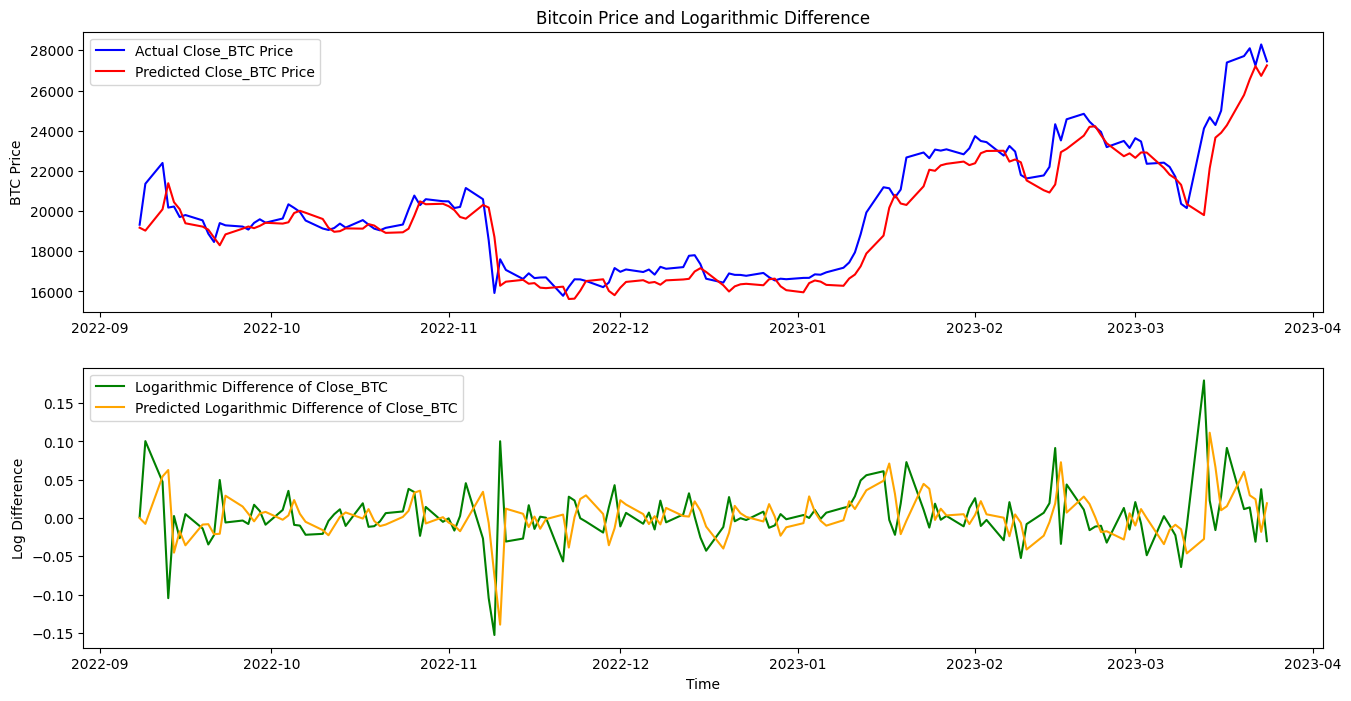

In [85]:
# Existing plot for 'Close_BTC' prices
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)  # First subplot in a 2x1 grid
plt.plot(actual_prices_aligned, label='Actual Close_BTC Price', color='blue')
plt.plot(predictions, label='Predicted Close_BTC Price', color='red')
plt.title('Bitcoin Price and Logarithmic Difference')
plt.ylabel('BTC Price')
plt.legend()

# New plot for 'Log_Diff_Close_BTC'
plt.subplot(2, 1, 2)  # Second subplot in a 2x1 grid
plt.plot(log_diff_actual, label='Logarithmic Difference of Close_BTC', color='green')
plt.plot(log_diff_predicted, label='Predicted Logarithmic Difference of Close_BTC', color='orange')
plt.xlabel('Time')
plt.ylabel('Log Difference')
plt.legend()

plt.show()